In [42]:
# Preface
...
# # reading in data as df
# df = pd.read_csv('Breast_Cancer.csv', delimiter=',')

# # correcting typos
# df = df.rename(columns={'T Stage ':'T Stage'})
# df = df.rename(columns={'Reginol Node Positive': 'Regional Node Positive'})

# # remapping target column
# df.loc[:,'Status_encoded'] = df.loc[:,'Status'].map({'Alive':0, 'Dead':1})

# # new features 
# # ['Node_Examined_Pos_Rate']: Positive Nodes per Examined Nodes
# df.loc[:,'Node_Exam_Pos_Rate'] = df.loc[:,'Regional Node Positive']/df.loc[:,'Regional Node Examined']
# #['Progesteron_Estrogen_Status']: Positive status if status of both receptors is positive
# mask = (df['Estrogen Status'] == 'Positive') | (df['Progesterone Status'] == 'Positive')
# conditions = [mask, ~mask]
# values = ['Positive', 'Negative']
# df['Estrogen_Progesteron_Status'] = np.select(conditions, values)


# # changing dtypes of columns as needed
# dtypes_columns = {'Age' : 'int64',
# 'Race' : 'category',
# 'Marital Status' : 'category',
# 'T Stage' : 'category', 
# 'N Stage' : 'category',
# '6th Stage' : 'category',
# 'differentiate' : 'category',
# 'Grade' : 'category',
# 'A Stage' : 'category', 
# 'Tumor Size' : 'int64',
# 'Estrogen Status' : 'category',
# 'Progesterone Status' : 'category',
# 'Regional Node Examined' : 'int64',
# 'Regional Node Positive' : 'int64',
# 'Survival Months' : 'int64',
# 'Status' : 'category',
# 'Status_encoded' : 'int64',
# 'Node_Exam_Pos_Rate': 'float64',
# 'Estrogen_Progesteron_Status': 'category'}
# df = df.astype(dtypes_columns)

# # drop 'Grade' columns because the information is the same as in the 'differentiate' column 
# df.drop('Grade', axis=1, inplace=True)



# # # creating target and features 
# # target = df.loc[:,'Status_encoded']
# # features = df.drop('Status', axis=1)
# # features = features.drop('Status_encoded', axis=1)

# # # train and test split
# # features_train, features_test, target_train, target_test = train_test_split(features, 
# #                                                                             target, 
# #                                                                             random_state=42,
# #                                                                             test_size=0.1)

In [43]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pickle
plt.style.use('seaborn')

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier # pipeline builder can handle

from sklearn.tree import plot_tree

C:\Users\kopyt\AppData\Local\Temp\ipykernel_7456\1183943992.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Data Gathering

In [44]:
# reading in data as df
df = pd.read_csv('Breast_Cancer.csv', delimiter=',')

# Preprocessing

In [45]:
def clean_data(df):
    """Returns cleaned DataFrame.
    
    Correcting typos
    Transform datatypes from object to category
    Drop column 'Grade'

    Args: 
        df (pd.DataFrame) : uncleaned DataFrame
        
    Returns:
        df  (pd.DataFrame) : cleaned DataFrame
    """
    # correcting typos
    df = df.rename(columns={'T Stage ':'T Stage'})
    df = df.rename(columns={'Reginol Node Positive': 'Regional Node Positive'})

    # remapping target column
    df.loc[:,'Status_encoded'] = df.loc[:,'Status'].map({'Alive':0, 'Dead':1})

    # changing dtypes of columns as needed
    dtypes_columns = {'Age' : 'int64',
        'Race' : 'category',
        'Marital Status' : 'category',
        'T Stage' : 'category', 
        'N Stage' : 'category',
        '6th Stage' : 'category',
        'differentiate' : 'category',
        'Grade' : 'category',
        'A Stage' : 'category', 
        'Tumor Size' : 'int64',
        'Estrogen Status' : 'category',
        'Progesterone Status' : 'category',
        'Regional Node Examined' : 'int64',
        'Regional Node Positive' : 'int64',
        'Survival Months' : 'int64',
        'Status' : 'category',
        'Status_encoded' : 'int64',
        'Node_Exam_Pos_Rate': 'float64',
        'Estrogen_Progesteron_Status': 'category'}
    df = df.astype(dtypes_columns)

    # drop 'Grade' columns because the information is the same as in the 'differentiate' column
    df.drop('Status', axis=1, inplace=True)
    df.drop('Grade', axis=1, inplace=True)

    return df

In [46]:
# save clean_data function as pickle
pickle.dump(clean_data, open('clean_data.p', 'wb'))

In [47]:
# load clean_data
file_name = 'clean_data.p'
clean_data = pickle.load(open(file_name, 'rb'))

In [48]:
def feature_engineering(df):
    """Add new Features to Dataframe.
    
    Add features Node_Exam_Pos_Rate and Estrogen Status
       
    Args:
        df (pd.DataFrame): Dataframe
        ohe_transformer: The fitted ohe_transformer
    
    Returns:
        (pd.DataFrame) : Dataframe with new Features
    """ 

    # ['Node_Examined_Pos_Rate']: Positive Nodes per Examined Nodes
    df.loc[:,'Node_Exam_Pos_Rate'] = df.loc[:,'Reginol Node Positive']/df.loc[:,'Regional Node Examined']

    #['Progesteron_Estrogen_Status']: Positive status if status of both receptors is positive
    mask = (df['Estrogen Status'] == 'Positive') | (df['Progesterone Status'] == 'Positive')
    conditions = [mask, ~mask]
    values = ['Positive', 'Negative']
    df['Estrogen_Progesteron_Status'] = np.select(conditions, values)

    return df
    

In [49]:
# save feature_engineering function as pickle
pickle.dump(feature_engineering, open('feature_engineering.p', 'wb'))

In [50]:
# load feature_engineering
file_name = 'feature_engineering.p'
feature_engineering = pickle.load(open(file_name, 'rb'))

In [51]:
# adding two new features
df = feature_engineering(df)

# clean dataframe
df_clean = clean_data(df)
df_clean.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Node_Exam_Pos_Rate,Estrogen_Progesteron_Status,Status_encoded
0,68,White,Married,T1,N1,IIA,Poorly differentiated,Regional,4,Positive,Positive,24,1,60,0.041667,Positive,0
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,Regional,35,Positive,Positive,14,5,62,0.357143,Positive,0
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,Regional,63,Positive,Positive,14,7,75,0.500000,Positive,0
3,58,White,Married,T1,N1,IIA,Poorly differentiated,Regional,18,Positive,Positive,2,1,84,0.500000,Positive,0
4,47,White,Married,T2,N1,IIB,Poorly differentiated,Regional,41,Positive,Positive,3,1,50,0.333333,Positive,0


# Train-Test Split

In [52]:
# creating target and features 
target = df_clean.loc[:,'Status_encoded']
#features = df.drop('Status', axis=1)
features = df_clean.drop('Status_encoded', axis=1)

# train and test split
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            random_state=42,
                                                                            test_size=0.1)

In [53]:
# save features_test and target_test as 'features_test.csv' and 'target_test.csv' respectively
features_test.to_csv('features_test.csv', index=False)
target_test.to_csv('target_test.csv', index=False)

# Baseline Model

In [54]:
# creating lists of categorical, ordinal and numerical columns
cat_cols = ['Race', 'Marital Status', 'Estrogen Status', 'Progesterone Status', 'Estrogen_Progesteron_Status']
ord_cols = ['T Stage', 'N Stage', '6th Stage', 'differentiate', 'A Stage']
num_cols = [col for col in features_train.select_dtypes(include=["int64","float64"])]

Our baseline model will be a DecisionTreeClassifier for easy interpretability.

First we have to deal with the inbalance of our target variable.

In [55]:
# testing different resampling methods
# running time: 9.3s

search_space = {'estimator__max_depth': range(2, 16, 2),
                'estimator__class_weight': [None, 'balanced']}
samplers = [('oversampling', RandomOverSampler(random_state=42)),
            ('undersampling', RandomUnderSampler(random_state=42)),
            ('class_weights', 'passthrough'),
            ('smote', SMOTE(random_state=42))
           ]
sampling_results = []

# go through every sampler
for name, sampler in samplers:
    # sampling
    imb_pipe = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                            ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                            ('ord_transformer', OrdinalEncoder(), ord_cols)
                        ], remainder='passthrough')),
                        ('sampler', sampler),
                        ('estimator', DecisionTreeClassifier(random_state=42))
                        ])
    
    # gridsearch and CV
    grid_tree = GridSearchCV(estimator=imb_pipe, 
                        param_grid=search_space,
                        n_jobs=-1,
                        cv=5,
                        scoring='f1')
    
    grid_tree.fit(features_train, target_train)

    target_pred_tree = grid_tree.predict(features_test)

    score = {'name': "DecisionTreeClassifier with " + name.upper(),
        'accuracy': accuracy_score(target_test, target_pred_tree) * 100,
        'precision': precision_score(target_test, target_pred_tree) * 100,
        'recall': recall_score(target_test, target_pred_tree) * 100,
        'f1': f1_score(target_test, target_pred_tree) * 100,
        'best model': grid_tree.best_estimator_.named_steps['estimator']
        }
    sampling_results.append(score)
# show results 
pd.DataFrame(sampling_results).T

,0,1,2,3
name,DecisionTreeClassifier with OVERSAMPLING,DecisionTreeClassifier with UNDERSAMPLING,DecisionTreeClassifier with CLASS_WEIGHTS,DecisionTreeClassifier with SMOTE
accuracy,89.081886,77.419355,92.059553,88.585608
precision,69.69697,42.657343,85.185185,70.0
recall,65.714286,87.142857,65.714286,60.0
f1,67.647059,57.276995,74.193548,64.615385
best model,"DecisionTreeClassifier(max_depth=4, random_sta...","DecisionTreeClassifier(max_depth=2, random_sta...","DecisionTreeClassifier(max_depth=2, random_sta...","DecisionTreeClassifier(max_depth=6, random_sta..."


We note that class_weights performs best for sampling. We will use the parameter class_weight for resampling our models.

TODO: Confusion Matrix für Baseline Modell und Baselien Modell in model_results Liste aufneheen

In [56]:
# list of metrics of all models
model_results = []

In [57]:
# our baseline model

pipeline_baseline = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                            ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                            ('ord_transformer', OrdinalEncoder(), ord_cols)
                        ], remainder='passthrough')),
                        ('estimator', DecisionTreeClassifier(class_weight='balanced', random_state=42))])

grid_tree = GridSearchCV(estimator=pipeline_baseline, 
                        param_grid=search_space,
                        n_jobs=-1,
                        cv=5,
                        scoring='f1')
grid_tree.fit(features_train, target_train)

# Print the training score of the best model
print("best score")
print(grid_tree.best_score_)

# Print the model parameters of the best model
print("best model parameter")
print(grid_tree.best_params_)

baseline_model = grid_tree.best_estimator_['estimator']
print("Baseline model", baseline_model)

# Print the val score of the best model
#predict
target_pred_tree = grid_tree.best_estimator_.predict(features_test)

#save
scores = {'name': "Baseline model",
          'accuracy': accuracy_score(target_test, target_pred_tree) * 100,
          'precision': precision_score(target_test, target_pred_tree) * 100,
          'recall': recall_score(target_test, target_pred_tree) * 100,
          'f1': f1_score(target_test, target_pred_tree) * 100,
        }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

best score
0.6088559433566457
best model parameter
{'estimator__class_weight': None, 'estimator__max_depth': 2}
Baseline model DecisionTreeClassifier(max_depth=2, random_state=42)


,0
name,Baseline model
accuracy,92.059553
precision,85.185185
recall,65.714286
f1,74.193548


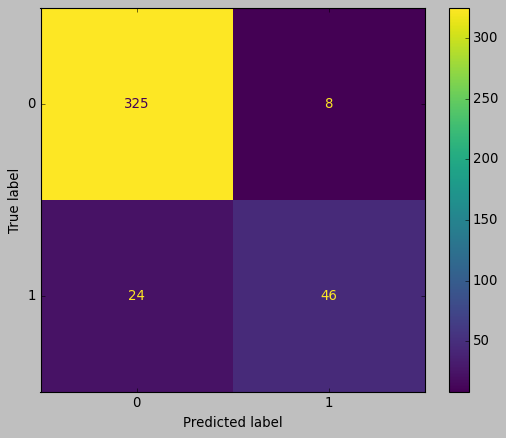

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix for predictions on test data
plt.style.use('classic')
test_pred = grid_tree.best_estimator_.predict(features_test)
confusion_matrix(target_test, test_pred)

ConfusionMatrixDisplay.from_estimator(grid_tree, features_test, target_test);

In [59]:
# report
report = classification_report(target_test, target_pred_tree)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       333
           1       0.85      0.66      0.74        70

    accuracy                           0.92       403
   macro avg       0.89      0.82      0.85       403
weighted avg       0.92      0.92      0.92       403



We plot our decision tree. TODO: Was zur Gini-Impurity sagen!

In [60]:
plot_tree(decision_tree=baseline_model,
          feature_names=grid_tree.estimator.named_steps['preprocessing'].get_feature_names_out(),
          class_names=['Alive','Dead'],
          filled=True);

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

We consider the roc-auc curve of our model.

In [ ]:
# print roc-curve

# create DataFrame with one column named prediction
df_pred_test = pd.DataFrame(target_pred_tree, columns=['prediction'])

# predict probabilities and add them as new column
df_pred_test.loc[:, 'probability'] = grid_tree.best_estimator_.predict_proba(features_test)[:, 1]  

# calculate roc-curve
from sklearn.metrics import roc_curve

false_positive_rate, recall, threshold = roc_curve(target_test, df_pred_test.loc[:, 'probability']) 

# plotting
plt.style.use('ggplot')

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--")  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall)

# labels
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("Recall");

# Training Models

# 1. RandomForestClassifier

In [61]:
# RandomForestClassifier with GridSearch
# running time: 4:12min to run

selected_features = cat_cols + ord_cols + num_cols


# creating baseline model pipeline
baseline_model = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                              ('cat_transformer', OneHotEncoder(drop='if_binary'), cat_cols), 
                              ('ord_transformer', OrdinalEncoder(), ord_cols)
                         ], remainder='passthrough')),
                         ('model', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))])

search_space_rfc = {'model__max_depth': np.geomspace(start=1, stop=250, num=10, dtype='int'),
                   'model__min_samples_leaf': np.geomspace(start=1, stop=40, num=10, dtype='int'),
                    'model__n_estimators': np.geomspace(start=25, stop=300, num=10, dtype='int')}

model_rfc = GridSearchCV(estimator=baseline_model,
                        param_grid=search_space_rfc,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)

# fitting model
model_rfc.fit(features_train[selected_features], target_train)

# Print the training score of the best model
print("best score ", model_rfc.best_score_)

# Print the model parameters of the best model
print("best model parameter ", model_rfc.best_params_)

target_test_pred_rfc = model_rfc.best_estimator_.predict(features_test)

scores = {'name': "RandomForestClassifier with all features selected",
          'accuracy': accuracy_score(target_test,target_test_pred_rfc) * 100,
          'precision': precision_score(target_test,target_test_pred_rfc) * 100,
          'recall': recall_score(target_test,target_test_pred_rfc) * 100,
          'f1': f1_score(target_test,target_test_pred_rfc) * 100,
         }
model_results.append(scores)
pd.DataFrame(model_results).T


KeyboardInterrupt: 

In [ ]:
# save best model_rfc as pickle
pickle.dump(model_rfc, open('model_rfc.p', 'wb'))

In [ ]:
# load model_rfc
file_name = 'model_rfc.p'
#with (open(file_name, "rb")) as f:
model_rfc = pickle.load(open(file_name, 'rb'))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix for predictions on test data
plt.style.use('classic')
test_pred = model_rfc.best_estimator_.predict(features_test[selected_features])
confusion_matrix(target_test, test_pred)

ConfusionMatrixDisplay.from_estimator(model_rfc, features_test[selected_features], target_test);

In [ ]:
# report
report = classification_report(target_test, target_test_pred_rfc)
print("Classification Report:\n", report)

In [ ]:
# print roc-curve

# create DataFrame with one column named prediction
df_pred_test = pd.DataFrame(target_test_pred_rfc, columns=['prediction'])

# predict probabilities and add them as new column
df_pred_test.loc[:, 'probability'] = model_rfc.best_estimator_.predict_proba(features_test)[:, 1]  

# calculate roc-curve
from sklearn.metrics import roc_curve

false_positive_rate, recall, threshold = roc_curve(target_test, df_pred_test.loc[:, 'probability']) 

# plotting
plt.style.use('ggplot')

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--")  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall)

# labels
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("Recall");

In [ ]:
from sklearn.model_selection import validation_curve

# set-up for validation curve: which max_depth-settings to try
search_space = range(2, 40,4)

# initialize figures with two axes
fig, ax = plt.subplots(ncols=3, figsize=[16, 4])
fig.suptitle('Validation curves of RandomForestClassifier')

# precision

# calculate precision values of different hyperparameter settings and cross validation folds
precision_train, precision_val = validation_curve(estimator=baseline_model.named_steps['model'], 
                                                  X=baseline_model.named_steps['preprocessing'].fit_transform(features_train, target_train), 
                                                  y=target_train, 
                                                  param_name='max_depth',
                                                  param_range=search_space,
                                                  cv=5,
                                                  scoring='precision')

# calculate average precision values for each hyperparameter setting
precision_train_mean = np.mean(precision_train, axis=1)
precision_val_mean = np.mean(precision_val, axis=1)

# plot validation curve
ax[0].plot(search_space,
           precision_train_mean, label='precision train')
ax[0].plot(search_space,
           precision_val_mean, label='precision validation')
ax[0].set(ylim=[0, 1.05],
          xlabel='Decision levels (max_depth)',
          ylabel='Precision score',
          title='Precision score and Decision levels')
ax[0].legend()

# recall

# calculate recall values of different hyperparameter settings and cross validation folds
recall_train, recall_val = validation_curve(estimator=baseline_model.named_steps['model'], 
                                            X=baseline_model.named_steps['preprocessing'].fit_transform(features_train, target_train), 
                                            y=target_train, 
                                            param_name='max_depth',
                                            param_range=search_space,
                                            cv=5,
                                            scoring='recall')

# calculate average recall values for each hyperparameter setting
recall_train_mean = np.mean(recall_train, axis=1)
recall_val_mean = np.mean(recall_val, axis=1)

# plot validation curve
ax[1].plot(search_space,
           recall_train_mean, label='recall train')
ax[1].plot(search_space,
           recall_val_mean, label='recall validation')
ax[1].set(ylim=[0, 1.05],
          xlabel='Decision levels (max_depth)',
          ylabel='Recall score',
          title='Recall score and Decision levels')
ax[1].legend()

# f1 score

# calculate precision values of different hyperparameter settings and cross validation folds
precision_train, precision_val = validation_curve(estimator=baseline_model.named_steps['model'], 
                                                  X=baseline_model.named_steps['preprocessing'].fit_transform(features_train, target_train), 
                                                  y=target_train, 
                                                  param_name='max_depth',
                                                  param_range=search_space,
                                                  cv=5,
                                                  scoring='f1')

# calculate average precision values for each hyperparameter setting
precision_train_mean = np.mean(precision_train, axis=1)
precision_val_mean = np.mean(precision_val, axis=1)

# plot validation curve
ax[2].plot(search_space,
           precision_train_mean, label='f1 train')
ax[2].plot(search_space,
           precision_val_mean, label='f1 validation')
ax[2].set(ylim=[0, 1.05],
          xlabel='Decision levels (max_depth)',
          ylabel='F1 score',
          title='F1 score and Decision levels')
ax[2].legend()

# 2. RandomForestClassifier with only the 12 most important features

In [ ]:
def feature_selection(grid):
    """Add new Features to Dataframe.
    
    Extract the 12 most important features of a given model.
       
    Args:
        df (pd.DataFrame): Dataframe
    
    Returns:
        (list) : list of column names
    """ 
    feature_importances = pd.DataFrame(grid.estimator.named_steps['classifier'].feature_importances_, index=grid.estimator.named_steps['preprocessing'].get_feature_names_out())
    feature_importances = feature_importances.sort_values(by=0, ascending=True)

    return feature_importances.tail(12).index

In [ ]:
# save feature_selection as pickle
pickle.dump(feature_selection, open('feature_selection.p', 'wb'))

In [ ]:
# load feature_selection
file_name = 'feature_selection.p'
#with (open(file_name, "rb")) as f:
feature_selection = pickle.load(open(file_name, 'rb'))

Folgende Code-Zeile löschen wir evntuell noch, da es noch nicht funktioniert

In [ ]:
# RandomForestClassification with feature selection
# don't work right now

# grid_log.estimator.steps[1][1].feature_importances_
# grid_rf.__dict__
# grid_log.estimator.steps[2][1]
# grid_log.estimator.__dict__
# grid_log.__dict__
# grid_rf.estimator.named_steps['classifier'].feature_importances_

most_important_features = feature_selection(grid_rf)
display(most_important_features)

# pipe with feature selection
pipe_rf = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                         ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                         ('ord_transformer', OrdinalEncoder(), ord_cols),
  			                  ('keep_cols', 'passthrough', most_important_features)
                      ], remainder='drop')),
                      ('classifier', grid_rf.estimator.named_steps['classifier'])])

# Train the RandomForestClassifier
pipe_rf.fit(features_train, target_train)

# Print the training score of the best model
print("best score", pipe_rf.best_score_)

# Print the model parameters of the best model
print("best model parameter", pipe_rf.best_params_)

pipe_rf.fit(features_train, target_train)

#predict
target_test_pred_rf_grid_sel = grid_rf.predict(features_test)

#save
scores = {'name': "RandomForest optimized with feature selection",
          'accuracy': accuracy_score(target_test, target_test_pred_rf_grid_sel) * 100,
          'precision': precision_score(target_test, target_test_pred_rf_grid_sel) * 100,
          'recall': recall_score(target_test, target_test_pred_rf_grid_sel) * 100,
          'f1': f1_score(target_test, target_test_pred_rf_grid_sel) * 100,
        }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

# 3. RandomForest with polynomial features

In [ ]:
# RandomForestClassifier with PolynomialFeatures
# running time: 25m 26.6s

from sklearn.preprocessing import PolynomialFeatures

#initate PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2,           
                                      interaction_only=False, # Controls whether self interactons are included 
                                      include_bias=False)    # Controls whether the 1 is also icluded as a feature

#create Pipeline
pipeline_rf_poly = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols)
                    ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ("poly", poly_transformer),
                    ('classifier', RandomForestClassifier(class_weight="balanced", random_state=42))])

# Create the parameter grid
grid_search_rf_poly = [{'classifier__max_depth':range(2, 40,4),#[10,11,12,13,14,15, 20],       
                  'classifier__max_features':[2, 3, 4, 5, 6, 8, 20,"auto"],
                  'classifier__min_samples_split':[2, 3, 4],
                  'classifier__min_samples_leaf':[2, 3, 4],
                  'classifier__n_estimators': np.arange(10,150,20)
                }]

# Create an instance of GridSearch 
grid_rf_poly = GridSearchCV(estimator=pipeline_rf_poly,
                    param_grid = grid_search_rf_poly,
                    scoring='f1',
                    cv=5,
                    n_jobs=-1)

# Train the RandomForestClassifier
grid_rf_poly.fit(features_train, target_train)

# Print the training score of the best model
print("best score")
print(grid_rf_poly.best_score_)

# Print the model parameters of the best model
print("best model parameter")
print(grid_rf_poly.best_params_)

#predict
target_test_pred_rf_poly_grid = grid_rf_poly.best_estimator_.predict(features_test)

#save
scores = {'name': "RandomForest with polynomial features",
          'accuracy': accuracy_score(target_test, target_test_pred_rf_poly_grid) * 100,
          'precision': precision_score(target_test, target_test_pred_rf_poly_grid) * 100,
          'recall': recall_score(target_test, target_test_pred_rf_poly_grid) * 100,
          'f1': f1_score(target_test, target_test_pred_rf_poly_grid) * 100,
        }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

In [ ]:
labels = ['Alive', 'Dead']
cm = confusion_matrix(target_test, target_test_pred_rf_poly_grid)
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, fmt='', xticklabels = labels, yticklabels = labels)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# report
report = classification_report(target_test, target_test_pred_rf_poly_grid)
print("Classification Report:\n", report)

In [ ]:
# print roc-curve

# create DataFrame with one column named prediction
df_pred_test = pd.DataFrame(target_test_pred_rf_poly_grid, columns=['prediction'])

# predict probabilities and add them as new column
df_pred_test.loc[:, 'probability'] = grid_rf_poly.best_estimator_.predict_proba(features_test)[:, 1]  

# calculate roc-curve
from sklearn.metrics import roc_curve

false_positive_rate, recall, threshold = roc_curve(target_test, df_pred_test.loc[:, 'probability']) 

# plotting
plt.style.use('ggplot')

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--")  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall)

# labels
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("Recall");

In [ ]:
# save grid_rf_poly as pickle

pickle.dump(grid_rf_poly, open('grid_rf_poly.p', 'wb'))

In [ ]:
# load grid_rf_poly
file_name = 'grid_rf_poly.p'
grid_rf_poly = pickle.load(open(file_name, 'rb'))

# 4. LogisticRegression

In [ ]:
# Logistic Regression

# scoring "recall": accuracy: 65.2, precision: 32, recall: 92.8, F1: 48.1
# using RobustScaler yields minimal improvement

from sklearn.preprocessing import PolynomialFeatures

# create Pipeline
pipeline_log = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols),
                     #('poly', PolynomialFeatures(degree=2, include_bias=False), num_cols),
                     ], remainder='passthrough')),
                    ('scaler', RobustScaler()),
                    ('classifier', LogisticRegression(solver="liblinear", class_weight='balanced', max_iter=1000, random_state=42))])

# create C_values
C_values = np.geomspace(0.001,1000,50) #[0.01, 0.1, 1, 10, 100]

# creat parameter Grid
grid_search_log = [{'classifier__penalty':["l2","l1"],
                    'classifier__C': C_values
                }]

# Create an instance of GridSearch Cross-validation estimator
grid_log = GridSearchCV(estimator=pipeline_log,
                     param_grid = grid_search_log,
                     scoring='f1',
                     cv=5,   
                     n_jobs=-1)

# Train the RandomForestClassifier
grid_log.fit(features_train, target_train)

# Print the training score of the best model
print("best score")
print(grid_log.best_score_)

# Print the model parameters of the best model
print("best model parameter")
print(grid_log.best_params_)

# Print the test score of the best model
#predict
target_test_pred_log_grid = grid_log.best_estimator_.predict(features_test)

#save
scores = {'name': "LogisticRegression_GridSearch",
          'accuracy': accuracy_score(target_test, target_test_pred_log_grid) * 100,
          'precision': precision_score(target_test, target_test_pred_log_grid) * 100,
          'recall': recall_score(target_test, target_test_pred_log_grid) * 100,
          'f1': f1_score(target_test, target_test_pred_log_grid) * 100,
         }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T 

best score
0.8698415346121768
best model parameter
{'classifier__C': 0.0017575106248547913, 'classifier__penalty': 'l1'}


,0,1,2,3,4,5,6,7,8,9,10
name,LogisticRegression_GridSearch,LogisticRegression_GridSearch_recall,LogisticRegression_GridSearch_RobustScaler,LogisticRegression_GridSearch,LogisticRegression_GridSearch_recall,LogisticRegression_GridSearch,LogisticRegression_GridSearch,LogisticRegression_GridSearch,LogisticRegression_GridSearch,LogisticRegression_GridSearch,LogisticRegression_GridSearch_recall
accuracy,82.133995,82.133995,82.382134,82.133995,82.133995,82.382134,82.382134,65.260546,65.260546,82.382134,65.260546
precision,49.107143,49.107143,49.54955,49.107143,49.107143,49.54955,49.54955,32.5,32.5,49.54955,32.5
recall,78.571429,78.571429,78.571429,78.571429,78.571429,78.571429,78.571429,92.857143,92.857143,78.571429,92.857143
f1,60.43956,60.43956,60.773481,60.43956,60.43956,60.773481,60.773481,48.148148,48.148148,60.773481,48.148148


In [ ]:
labels = ['Alive', 'Dead']
cm = confusion_matrix(target_test, target_test_pred_log_grid)
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, fmt='', xticklabels = labels, yticklabels = labels)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# report
report = classification_report(target_test, target_test_pred_log_grid)
print("Classification Report:\n", report)

In [ ]:
# print roc-curve

# create DataFrame with one column named prediction
df_pred_test = pd.DataFrame(target_test_pred_log_grid, columns=['prediction'])

# predict probabilities and add them as new column
df_pred_test.loc[:, 'probability'] = grid_log.best_estimator_.predict_proba(features_test)[:, 1]  

# calculate roc-curve
from sklearn.metrics import roc_curve

false_positive_rate, recall, threshold = roc_curve(target_test, df_pred_test.loc[:, 'probability']) 

# plotting
plt.style.use('ggplot')

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--")  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall)

# labels
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("Recall");

In [ ]:
# save grid_log as pickle

pickle.dump(grid_log, open('grid_log.p', 'wb'))

In [ ]:
# load grid_log
file_name = 'grid_log.p'
grid_log = pickle.load(open(file_name, 'rb'))

# 5. Support Vector Machine with Gaussian kernel

In [ ]:
#Support Vector Machine with Gaussian kernel
# running time: 12.9s

from sklearn.svm import SVC 

# create Pipeline
pipeline_svc = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols)
                    ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ('classifier', SVC(C=1000, kernel="rbf", gamma='scale', class_weight='balanced', random_state=42))])

# create k values
k = np.geomspace(1,1000,10, dtype="int")
k = np.unique(k)

# Create the parameter grid
grid_search_svc = [{'classifier__C':[0.1,1, 10, 100],
                   'classifier__gamma':[0.001,0.01,0.1, 1, 10]
                    }]

# Create an instance of GridSearch Cross-validation estimator
grid_svc = GridSearchCV(estimator=pipeline_svc,
                     param_grid = grid_search_svc,
                     scoring='f1',
                     cv=3,
                     verbose =1,
                     n_jobs=-1)

# fit the Model
grid_svc.fit(features_train, target_train)

# Print the training score of the best model
print("best score")
print(grid_svc.best_score_)

# Print the model parameters of the best model
print("best model parameter")
print(grid_svc.best_params_)

# Print the test score of the best model
#predict
target_test_pred_svc_grid = grid_svc.predict(features_test)

#save
scores = {'name': "SVC with Gaussian kernel and GridSearch",
          'accuracy': accuracy_score(target_test, target_test_pred_svc_grid) * 100,
          'precision': precision_score(target_test, target_test_pred_svc_grid) * 100,
          'recall': recall_score(target_test, target_test_pred_svc_grid) * 100,
          'f1': f1_score(target_test, target_test_pred_svc_grid) * 100,
         }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix for predictions on test data
plt.style.use('classic')
test_pred = grid_svc.best_estimator_.predict(features_test)
confusion_matrix(target_test, test_pred)

ConfusionMatrixDisplay.from_estimator(grid_svc, features_test, target_test);

In [ ]:
# report
report = classification_report(target_test, target_test_pred_svc_grid)
print("Classification Report:\n", report)

In [ ]:
# save grid_log as pickle

pickle.dump(grid_svc, open('grid_svc.p', 'wb'))

In [ ]:
# load grid_svc
file_name = 'grid_svc.p'
grid_svc = pickle.load(open(file_name, 'rb'))

In [ ]:
# # print roc-curve

# # create DataFrame with one column named prediction
# df_pred_test = pd.DataFrame(target_test_pred_svc_grid, columns=['prediction'])

# # predict probabilities and add them as new column
# df_pred_test.loc[:, 'probability'] = grid_svc.best_estimator_.predict_proba(features_test)[:, 1]  

# # calculate roc-curve
# from sklearn.metrics import roc_curve

# false_positive_rate, recall, threshold = roc_curve(target_test, df_pred_test.loc[:, 'probability']) 

# # plotting
# plt.style.use('ggplot')

# # figure and axes intialisation
# fig, ax = plt.subplots()

# # reference lines
# ax.plot([0, 1], ls = "--")  # blue diagonal
# ax.plot([0, 0], [1, 0], c=".7", ls='--')  # grey vertical
# ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# # roc curve
# ax.plot(false_positive_rate, recall)

# # labels
# ax.set_title("Receiver Operating Characteristic")
# ax.set_xlabel("False Positive Rate")
# ax.set_ylabel("Recall");